In [3]:
import os
os.getcwd()

'/users/eleves-b/2023/thomas.gastellu/TDs/CSC_43M04_EP_challenge/flashy'

**Step 0 :** Set the execution directory to ensure this runs correctly

In [ ]:
# os.chdir('/p/to/your/directory')

**Step 1 :** Load the meta data from the train_val.csv file with pandas. Run a quick print statement to check if the file was corectly parsed. 

In [5]:
import pandas as pd

df = pd.read_csv("../dataset/train_val.csv")  # Has title, channel, views, etc.

# Print info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")

# For each column, print its name and first 20 values
for column in df.columns:
    print(f"\n{'='*50}")
    print(f"Column: {column}")
    print(f"{'='*50}")
    
    # Handle different display formats based on data type
    if df[column].dtype == 'object':  # For string columns
        for i, value in enumerate(df[column].head(20)):
            print(f"{i+1}. {value}")
    else:  # For numeric columns
        print(df[column].head(20).to_string())
    
    print()


DataFrame shape: (15482, 8)
Columns: ['Unnamed: 0', 'id', 'channel', 'title', 'date', 'description', 'views', 'year']


Column: Unnamed: 0
0      0
1      1
2      2
3      6
4     10
5     12
6     13
7     14
8     15
9     16
10    17
11    18
12    19
13    21
14    23
15    24
16    25
17    27
18    28
19    29


Column: id
1. --2s6hjGrm4
2. --DnfroyKQ8
3. --aiU7VQKEw
4. -0SrlZAvSVM
5. -13Y2Pe7kFs
6. -1ElNi3aewU
7. -1FZlgerlnQ
8. -1enK4XQvow
9. -1hANFUO3yc
10. -1nkzRrnVfA
11. -2G5aWo41FI
12. -2GXUooP7RA
13. -2QKZNWHaiw
14. -2nyTzsnfrQ
15. -33JjmUgM2A
16. -37nwIsz2BM
17. -38KYLeEfHU
18. -4eq9OGlkYw
19. -5Yye_6--lk
20. -5cvOGIezgc


Column: channel
1. UC-1rx8j9Ggp8mp4uD0ZdEIA
2. UC-1rx8j9Ggp8mp4uD0ZdEIA
3. UC-1rx8j9Ggp8mp4uD0ZdEIA
4. UCW6NyJ6oFLPTnx7iGRZXDDg
5. UC-1rx8j9Ggp8mp4uD0ZdEIA
6. UC-1rx8j9Ggp8mp4uD0ZdEIA
7. UCXLfJIEp91L-fD0gP131IaQ
8. UC-1rx8j9Ggp8mp4uD0ZdEIA
9. UC-1rx8j9Ggp8mp4uD0ZdEIA
10. UCW6NyJ6oFLPTnx7iGRZXDDg
11. UCrSvhrtUgpZT3EU0x1Zoy-w
12. UCrSvhrtUgpZT3EU0x1Zoy-w


**Step 2 :** Calculate topic embeddings using a sentence tranformer

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def make_text(row):
    return f"{row['title']} | {row['channel']} | {row['date']}"

texts = df.apply(make_text, axis=1).tolist()
topic_embeddings = model.encode(texts, convert_to_tensor=True, normalize_embeddings=True)

**Step 3 :** Calculate FAISS index (optimized index for knn search in high dimensional space)

In [7]:
import faiss
import numpy as np

index = faiss.IndexFlatIP(topic_embeddings.shape[1])  # inner product = cosine sim (normalized)
index.add(topic_embeddings.cpu().numpy())

k = 10  # number of neighbors
_, neighbors = index.search(topic_embeddings.cpu().numpy(), k+1)  # +1 to exclude self

view_counts = df['views'].values
flashiness = []




for i, n in enumerate(neighbors):
    neighbor_views = view_counts[n[1:]]  # skip self
    relative_view = view_counts[i] / (neighbor_views.mean() + 1e-6)
    score = np.log1p(relative_view)  # optional smoothing/log
    flashiness.append(score)

df["flashiness"] = flashiness

**Step 4 :** Store results in a new csv, that has the falshiness score in an extra column

In [8]:
df.to_csv("../dataset/train_with_flashiness.csv", index=False)

**Step 5 :** Plot results (see if it seems somewhat coherent)

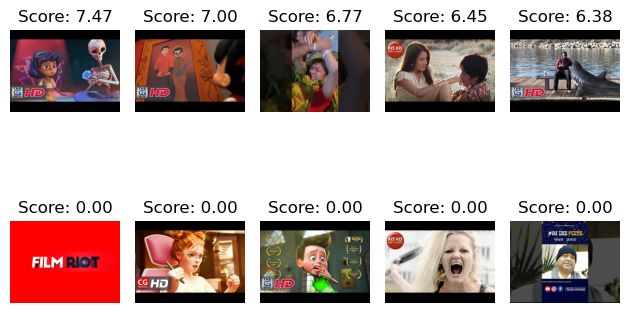

In [10]:
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv("../dataset/train_with_flashiness.csv")
df_sorted = df.sort_values(by='flashiness', ascending=False)

# Number of examples to show from each end
n_examples = 5

plt.subplot(1, 2, 1)
plt.title("Highest Flashiness Scores", fontsize=16)
    
for i in range(min(n_examples, len(df_sorted))):
    row = df_sorted.iloc[i]
    img_path = os.path.join("../dataset/train_val", f"{row['id']}.jpg")
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(2, n_examples, i+1)
        plt.imshow(img)
        plt.title(f"Score: {row['flashiness']:.2f}")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

# Display examples with lowest flashiness scores
for i in range(min(n_examples, len(df_sorted))):
    row = df_sorted.iloc[len(df_sorted) - i - 1]
    img_path = os.path.join("../dataset/train_val", f"{row['id']}.jpg")
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(2, n_examples, n_examples + i + 1)
        plt.imshow(img)
        plt.title(f"Score: {row['flashiness']:.2f}")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()